# Survival Analysis

In this project we will use survival analysis, the aim of this analysis is to measure the 'time to event’ by estimating the time to which the observed will go through an event we are interested in. The event of interest here being when a customer will cancel their subscription. We will not observe this event for all of our customers.

# 1. Import Libaries

In [12]:
# !pip install scikit-plot
# !pip install lifelines

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.gridspec import GridSpec

plt.style.use('fivethirtyeight')
%matplotlib inline
palette = itertools.cycle(sns.color_palette())

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
from lifelines import WeibullAFTFitter
from lifelines.statistics import logrank_test
from lifelines.utils import restricted_mean_survival_time
from lifelines.plotting import rmst_plot
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from numpy.random import uniform, exponential

# 2. Import Data

Lets import two datasets and merge them.

1. Customer Data

In [2]:
columns = ['customerid','client_status','account_status','customer_name','customer_type','value','year_of_current_deal','cancellation_timing','sector','cancellation_reason']
renewals = pd.read_csv('~/Documents/portfolio/datasets/Renewal-Cancelation Book Anonymised3.csv', names=columns, header=0)
renewals.sample(5)

,customerid,client_status,account_status,customer_name,customer_type,value,year_of_current_deal,cancellation_timing,sector,cancellation_reason
852,1476,Mid,Inactive,147,Two,4950,1,Mid-term,General,Switched to competitor
337,441,Mid,Inactive,1053,Three,4750,1,NaN,Insurance,No longer required
793,1754,Mid,Active,834,Three,3000,2,NaN,Charity,NaN
676,1520,High,Active,277,Three,4950,2,NaN,Financials,NaN
1135,1824,High,Active,709,Two,4950,2,NaN,Travel & Leisure,NaN


To give a description of each variable above:

<br>

<b>customerid</b> : 
a unique identifier for each account that will be used to join additional datasets later on 

<b>client_status</b> : 
a grading system of the account given by the account manager that denotes the level of usage and engagement, high means no cause for concern as high engagement and usage and low means little/no usage and engagement, high risk of cancellation.

<b>account_status</b> : 
denotes whether the client is active (paying customer) or inactive (cancelled)

<b>customer_name</b> : 
customer number     

<b>customer_type</b> : 
we categorise into three pots of client according to size in revenue; one being the smallest, and three being the largest.

<b>value</b> : 
the current price of subscription, there are three types of subcription for which the prices differ and this is dependent on the customer type.

<b>year_of_current_deal</b> : 
the year of maturity of the account

<b>cancellation_timing</b> : 
shows if the cancellation was at the start of a period or mid way through

<b>sector</b>: 
the industry that the customer operates in 

<b>cancellation_reason</b> : 
a reason for cancellation picked from a preset list of reasons

2. Usage Data

In [3]:
usage = pd.read_csv('~/Documents/portfolio/datasets/usage report duration.csv')
usage.rename(columns={'CustomerId':'customerid'},inplace=True)
usage.head()

,customerid,year,0,1,2,3,4,5,6,7,...,37,38,39,40,Duration,First month usage,Total Logins,Number of Users,Number of Active Users,Difference in total users and active
0,1452,1,451,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,451,451,25,17,8
1,160,2,3,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,3,3,4,1,3
2,1809,1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,1,1,1,0
3,168,1,33,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,33,33,1,1,0
4,2388,1,9,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,9,9,2,1,1


The next dataset shows the number of sessions the customer has had on our platform each month (months numbered 0 to 40), first month usage, number of users, number of active users, and the difference between total users and active. Active meaning the user has logged in and used the platform at least once.

In [4]:
# Merging the two datasets on customer id, which is unique to every customer, dropping any customers in the usage dataset for 
# which we don't have renewal data for.

renewals_usage = pd.merge(renewals, usage, on=['customerid'])
renewals_usage.shape

(1134, 58)

# 3. Data Cleaning

In [5]:
# Dropping any unwanted columns. 

renewals_usage.drop(columns=['cancellation_timing','sector','cancellation_reason','client_status'],
              inplace=True)

In [6]:
renewals_usage.isnull().sum()

customerid                                 0
account_status                             0
customer_name                              0
customer_type                              0
value                                      0
year_of_current_deal                       0
year                                       0
0                                          0
1                                         21
2                                          0
3                                         87
4                                        119
5                                        155
6                                        200
7                                        237
8                                        258
9                                        290
10                                       321
11                                       350
12                                       386
13                                       458
14                                       511
15        

In [7]:
# Checking for duplicate entries for clients

renewals_usage.customer_name.value_counts()

569    4
21     2
386    1
379    1
380    1
      ..
760    1
759    1
758    1
757    1
1      1
Name: customer_name, Length: 1130, dtype: int64

In [8]:
# locating the rows of the duplicate accounts and checking both rows have the same information before deleting one

duplicate_name = renewals_usage.customer_name == 569
renewals_usage[duplicate_name]

,customerid,account_status,customer_name,customer_type,value,year_of_current_deal,year,0,1,2,...,37,38,39,40,Duration,First month usage,Total Logins,Number of Users,Number of Active Users,Difference in total users and active
167,1490,Inactive,569,Two,10500,1,1,1,114.0,0,...,NaN,NaN,NaN,NaN,2,1,115,23,12,11
168,1490,Inactive,569,Two,10500,1,1,144,457.0,473,...,NaN,NaN,NaN,NaN,15,144,4485,23,12,11
169,1490,Inactive,569,Two,10500,1,1,1,114.0,0,...,NaN,NaN,NaN,NaN,2,1,115,23,12,11
170,1490,Inactive,569,Two,10500,1,1,144,457.0,473,...,NaN,NaN,NaN,NaN,15,144,4485,23,12,11


In [9]:
duplicate_name = renewals_usage.customer_name == 21
renewals_usage[duplicate_name]

,customerid,account_status,customer_name,customer_type,value,year_of_current_deal,year,0,1,2,...,37,38,39,40,Duration,First month usage,Total Logins,Number of Users,Number of Active Users,Difference in total users and active
336,286,Inactive,21,Two,4800,1,1,71,16.0,66,...,NaN,NaN,NaN,NaN,8,71,302,16,10,6
337,286,Inactive,21,Two,4800,1,1,52,12.0,35,...,NaN,NaN,NaN,NaN,32,52,725,16,10,6


In [10]:
# deleting the one duplicate row where the cancellation reason is unknown

renewals_usage.drop(renewals.index[167], inplace = True)
renewals_usage.drop(renewals.index[168], inplace = True)
renewals_usage.drop(renewals.index[169], inplace = True)
renewals_usage.drop(renewals.index[336], inplace = True)


In [11]:
# checking the format of the variables

renewals_usage.dtypes

customerid                                int64
account_status                           object
customer_name                             int64
customer_type                            object
value                                     int64
year_of_current_deal                      int64
year                                      int64
0                                         int64
1                                       float64
2                                         int64
3                                       float64
4                                       float64
5                                       float64
6                                       float64
7                                       float64
8                                       float64
9                                       float64
10                                      float64
11                                      float64
12                                      float64
13                                      

In [12]:
# mapping the active and inactive customers to either 1 or 0

renewals_usage['account_status_map'] = renewals_usage.account_status.map({'Inactive':0, 'Active':1})

In [13]:
# number of active and inactive customers in the dataset

renewals_usage.account_status.value_counts()

Active      889
Inactive    241
Name: account_status, dtype: int64

In [14]:
# dropping the account status column now we have mapped in a new column

renewals_usage.drop(columns=['account_status'],
              inplace=True)

# 4. Survival Analysis

Below is a plot of a subset of the data to illustrate the aim of this analysis, each line represents the duration of a customer where blue lines are live customers and red are cancelled. The live customers have not cancelled and so they are our right censored group; we do not know how their life span will be before they may cancel. The following analysis we do will be to estimate the life span of our right censored customers, to help us predict when customers will churn. 

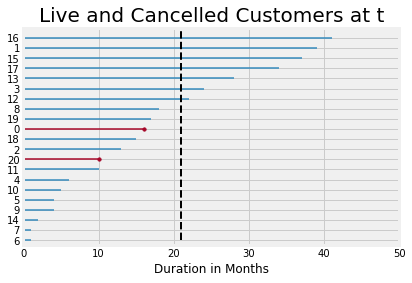

In [16]:
N=41

CURRENT_TIME = 10

renewals_sample = renewals_usage[:-1109] #slicing the data to get a smaller subset

ax = plot_lifetimes(renewals_sample['Duration'], event_observed=renewals_sample['account_status_map'] == 0, figsize = (20,50))
ax.set_xlim(0, 50)
ax.vlines(21, 0, 50, lw=2, linestyles='--')
ax.set_xlabel('Duration in Months')
ax.set_title('Live and Cancelled Customers at t', fontsize = 20);

We can fit the KaplanMeier to give a survival curve to display the estimated probability of the customer's survival (live subscription) over time. The curve shows there is an 80% chance a customer's subscription lasts for approximately 9 months and a 40% chance they last for around 25 months. Finally there is a 20% chance a customer's subscription will last for 40 months.

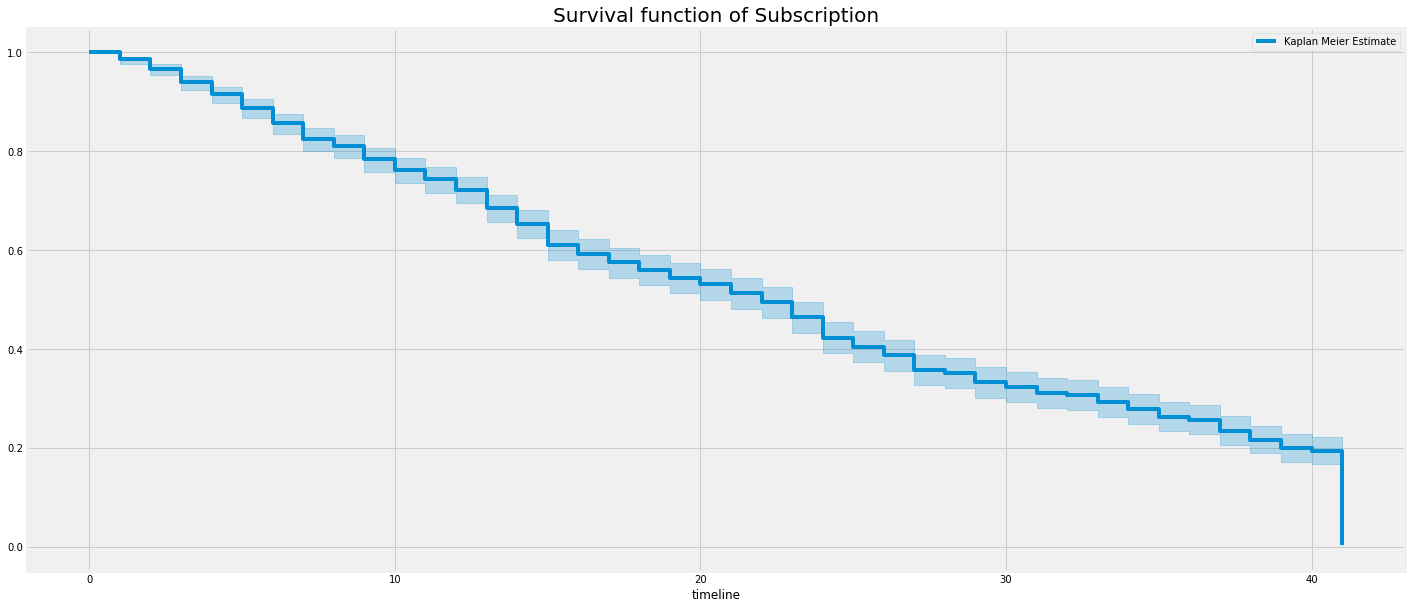

In [17]:
kmf = KaplanMeierFitter()

data = renewals_usage
duration = data["Duration"] # time variable
event = data["account_status_map"] # event observed

kmf.fit(duration, event_observed=event,label='Kaplan Meier Estimate')

kmf.plot(figsize = (22,10))
plt.title('Survival function of Subscription', fontsize=20);

Fitting the KaplanMeier for a second time, we can get more granular; this time to display the estimated probability of the customer's survival (live subscription) over time based on the customer type. Here we can see that for the first year the probability of survival is the same irrespective of customer type. However, at the beginning of year 2 we can see a gap starting to appear whereby customer type 'Three's are expected to survive longer at any given probability value. For example, there is a 40% chance that 'One's and 'Two's survive to 24 months, compared to the 27 months for 'Three's. 

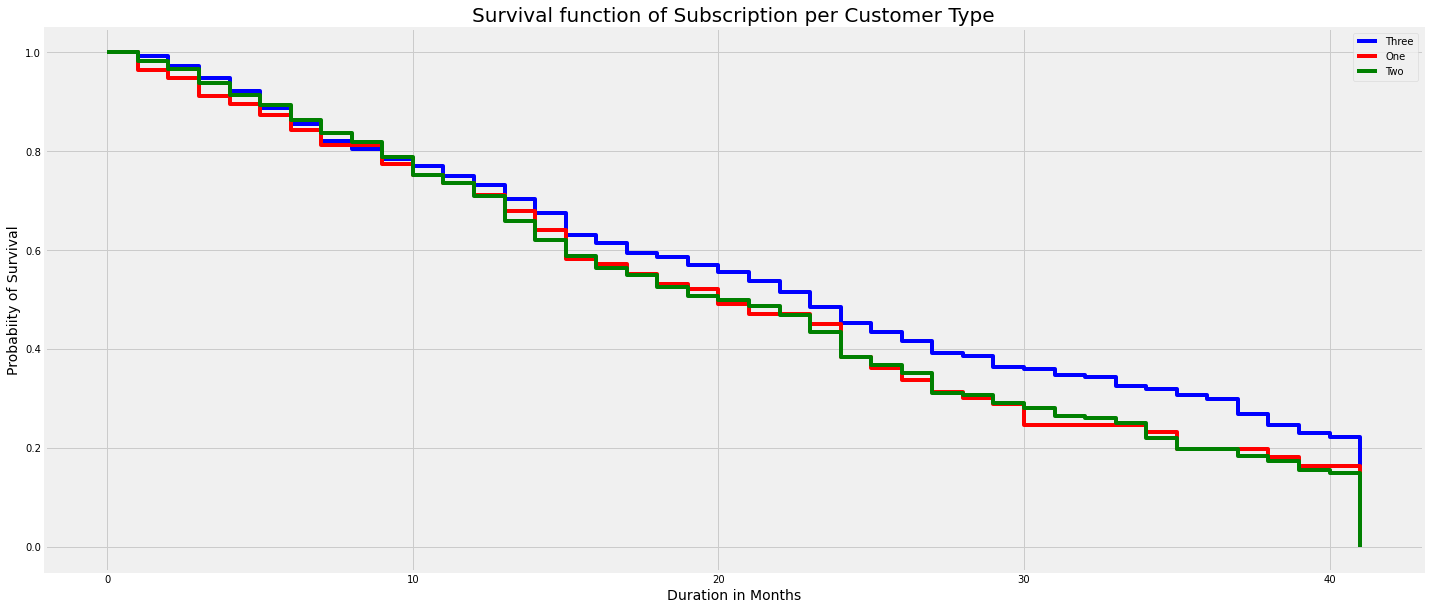

In [18]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

# 3 customer types are compared. 
groups = renewals_usage['customer_type']   
i1 = (groups == 'Three')      
i2 = (groups == 'One')  
i3 = (groups == 'Two') 


# fit the model for first type
kmf1.fit(duration[i1], event[i1], label='Three')
a1 = kmf1.plot(ci_show=False, figsize = (22,10), color='b') # not plotting the confidence level lines because makes the graph
                                                            # harder to read

# fit the model for second type
kmf1.fit(duration[i2], event[i2], label='One')
kmf1.plot(ax=a1, ci_show=False, color='r')

# fit the model for third type
kmf1.fit(duration[i3], event[i3], label='Two')
kmf1.plot(ax=a1, ci_show=False, color='g')

plt.title('Survival function of Subscription per Customer Type', fontsize=20);
plt.xlabel('Duration in Months', fontsize = 14);
plt.ylabel('Probabiity of Survival', fontsize = 14);

In [19]:
# Creating a subset of data to just include the variables for the next plot

renewals_usage_two= renewals_usage.loc[:,[
       'account_status_map','Duration','Total Logins',
       'Number of Active Users','value','First month usage','Difference in total users and active']]


In [20]:
renewals_usage_two.shape

(1130, 7)

In [21]:
renewals_usage_two.isnull().sum()

account_status_map                      0
Duration                                0
Total Logins                            0
Number of Active Users                  0
value                                   0
First month usage                       0
Difference in total users and active    0
dtype: int64

In [22]:
renewals_usage_two.head()

,account_status_map,Duration,Total Logins,Number of Active Users,value,First month usage,Difference in total users and active
0,0,16,339,1,4950,30,2
1,1,39,241,7,5030,10,0
2,1,13,495,10,5500,37,4
3,1,24,347,7,4950,12,0
4,1,6,577,6,6050,97,0


The Hazard Function is defined as the probability that the subject will experience an event of interest within a time interval. We can use the Cox Proportional Hazard Model to show the impact of the covariates on the survival curve. 

In [23]:
# fitting the regression

cph = CoxPHFitter().fit(renewals_usage_two, 'Duration', event_col = 'account_status_map')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1130 total observations, 241 right-censored observations>
             duration col = 'Duration'
                event col = 'account_status_map'
      baseline estimation = breslow
   number of observations = 1130
number of events observed = 889
   partial log-likelihood = -5268.20
         time fit was run = 2021-07-19 14:21:00 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
Total Logins                          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Number of Active Users                 0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
value                                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
First month usage                      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Difference in total users and active  -0.00       1.00       0.01            -0.02             0.01                 0.99                 1.01

                                         z      p   -log2(p)
covariate                                                   
Total Logins                         -6.62 <0.005      34.71
Number of Active Users                2.76   0.01       7.45
value                                 0.64   0.52       0.94
First month usage                     3.76 <0.005      12.50
Difference in total users and active -0.04   0.97       0.04
---
Concordance = 0.67
Partial AIC = 10546.41
log-likelihood ratio test = 65.50 on 5 df
-log2(p) of ll-ratio test = 40.04

When considering the coefficients (0.01) in the summary below it looks as though only 'Number of Active Users' is the only variable that contribute to predicting the surivival curve. Let's plot them to look closer.

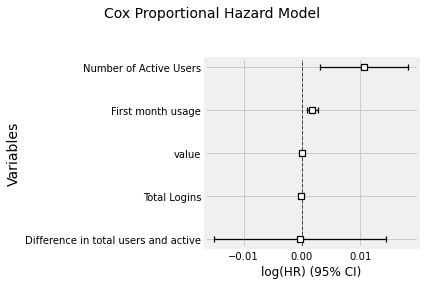

In [24]:
# plotting the coefficients and their ranges

p=cph.plot();
plt.ylabel('Variables', fontsize = 14);
plt.tight_layout() 

plt.suptitle('Cox Proportional Hazard Model', fontsize=14);
plt.subplots_adjust(top=0.8)


The graph above indicates that 'Number of Active Users' has the greatest positive impact in predicting the churn risk. The first month of logins also has a positive impact but it is smaller, hence the coefficient above is (0.00). The 'Difference in total users and active' has the largest impact on predicting the survival function, however this can be both negative and positive depending on the value. 'Total Logins' and 'value' look to have no impact on the curve. 

The baseline hazard shows the inverse of the survival probabality plot as it shows the probability that a customer cancels in that month. 

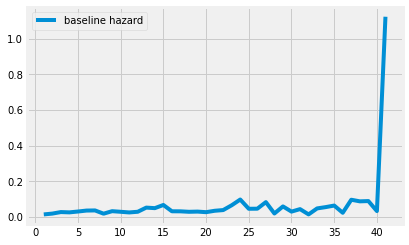

In [25]:
cph.baseline_hazard_.plot();

We can see overall the baseline hazard is consistently low, and at most only 0.1 for some durations. For example, a small spike at 24 months.

We would expect that as the total number of logins for an account increases the probablity that they will survive for longer increases. Let's plot the survival function for different values of total logins to see. 

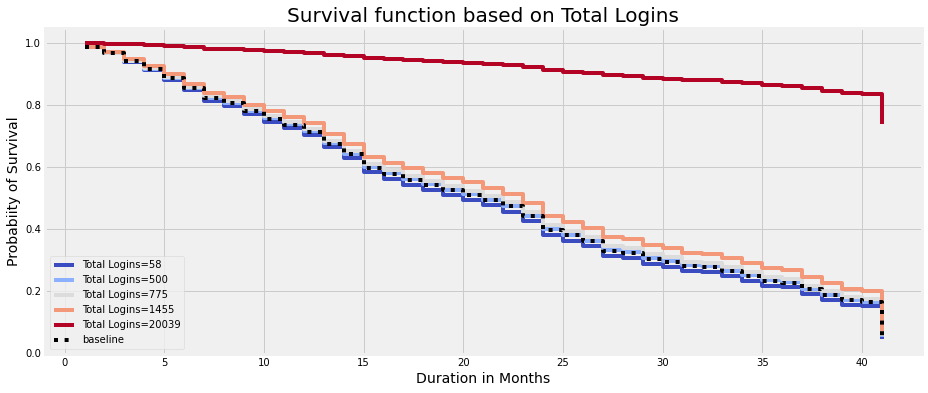

In [34]:
cph.plot_partial_effects_on_outcome(covariates='Total Logins', values=[58,500,775,1455,20039], figsize=(14,6), 
                                    cmap='coolwarm')
plt.title('Survival function based on Total Logins', fontsize=20);
plt.xlabel('Duration in Months', fontsize = 14);
plt.ylabel('Probabiity of Survival', fontsize = 14);

On first glance it looks as though there are high outliers in the total logins data, shown by a nearly 100% probablity of survival if the total logins are around 20,039. We can see that for total logins around 58 the survival probablity is just below the baseline, and 500 is just on the baseline. However, at 775 the probablity of survival is slightly higher. Therefore, if we want to increase the probablity of survival above the baseline we need to push for total logins of greater than 500.

# 5. Conclusion

We have shown that there is an 80% chance that a customer's subscription lasts for approximately 9 months and a 40% chance they last for around 25 months. And that at the beginning of year 2 we can see a gap starting to appear whereby customer type 'Three's are expected to survive longer at any given probability value. 'Number of Active Users' has the greatest positive impact in predicting the churn risk and total logins of 500 increases the probablity of survival above the baseline.

Therefore, we should drive engagement through number of active users and total logins in the first 9 months to increase the chances of survival. In addition, we can decide our strategy based on what we know our largest risks to cashflow are; whether that be focusing on increasing the probablity of survival for customer type 'Three's because they are of highest value or because 'Two's and 'One's have a lower probabalitiy of surivival at any given time past 12 months.

Next steps in going further to answer the problem I posed will be to;

1) explore the lifeline documentation more.

2) drill down into other data points available. 
- we could use the percentage of inactive users of the total to make comparisons between small and larger businesses. 
- looking into attendence of our webinar events. 
- time spent negotiating the contract may be an interesting data point to introduce; are accounts that go through more approval processes, spent longer reviewing pricing and t&cs more likely to have done their research on competitors, and so are more confident in their need for us and less likely to cancel? This is a stat we would have on day 1 of subscription and so may offer more complexity to the models. 

3) be able to highlight a series of red flags to the accounts, marketing and finance teams whereby a particular account is at risk of cancelling given the probability. This will enable account managers to call/ arrange extra training sessions, the marketing team to send targeted content to sectors, customer types in varying degrees of pushiness depending on the risk denoted by the survival probablity, both to encourage engagement and drive up the survival curve. And finally to the finance team to review the confidence weighting of receiving payment for particular accounts, types or at different durations into subscription to improve the accuracy of forecasting cashflow.